### Simple AR Program
1) Compute point correspondences (2D and AR tag) <br>
2) Estimate the pose of the camera <br>
3) Project 3D content to the image plane

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import glob

import warnings
warnings.filterwarnings("ignore")

**Inputting the video frames**

In [2]:
FRAMES_PATH = "data/apriltagims/*"

video_frame_paths = glob.glob(FRAMES_PATH)
video_frame_paths.sort()

In [3]:
initial_points = 1.0e+02 * np.array([[1.981631469726562,3.165294189453125],
                                    [3.786268920898438,3.424402770996094],
                                    [4.036800842285157,1.686005859375000],
                                    [2.333528289794922,1.491907043457031]])

K = 1.0e+02 * np.array([[7.661088867187500, 0, 3.139585628047498],
                        [0, 7.699354248046875,  2.503607131410900],
                        [0 ,                  0,   0.010000000000000 ]])
num_frames = 166
tag_width = 0.13;
tag_height = 0.13;
cube_depth = 0.13;

corner_pts = np.array([[  tag_width/2,  tag_height/2],
               [-tag_width/2,  tag_height/2],
               [-tag_width/2, -tag_height/2],
               [tag_width/2, -tag_height/2]])

**Implement KLT Tracking**

In [4]:
video_imgs = []

for frame_path in video_frame_paths:
    frame = cv2.imread(frame_path)
    video_imgs.append(frame)
    
video_imgs=np.array(video_imgs)

In [5]:
class KLTtrack():
    def __init__(self,imglist,trackpts):
        self.vid = imglist
        self.pts = trackpts
        # Parameters for lucas kanade optical flow
        self.lk_params = dict(winSize  = (31,31),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 5, 0.03))

    def pointTracker(self):
        # Create some random colors
        color = np.random.randint(0,255,(self.pts.shape[0],3))
        # Take first frame and find corners in it
        old_frame = self.vid[0,:,:,:]
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        p0 = np.floor(self.pts).reshape(-1,1,2).astype(np.float32)
        
        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)
        corners = []
        corners.append(self.pts)

        for i in range(1,len(self.vid)):
            frame = video_imgs[i,:,:,:]
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # calculate optical flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)
            # Select good points
            good_new = p1[st==1]
            good_old = p0[st==1]
            # draw the tracks
            for i,(new,old) in enumerate(zip(good_new, good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
            img = cv2.add(frame,mask)

            k = cv2.waitKey(5) & 0xff
            if k == 27:
                break
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            corners.append(good_new)
            p0 = good_new.reshape(-1,1,2)
            
        return np.array(corners)

In [6]:
def track_corners(video_frames, initial_pts):
        
    tracker = KLTtrack(video_frames, initial_points)
    
    return tracker.pointTracker()

In [7]:
corners = track_corners(video_imgs, initial_points)

In [8]:
corners.shape

(166, 4, 2)

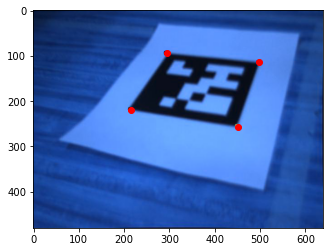

In [9]:
i = np.random.randint(num_frames)

plt.imshow(video_imgs[i,:,:,:])
plt.plot(corners[i,:,0],corners[i,:,1],'ro')
plt.show()

**Homography Estimation**

In [10]:
from utils import vectorize, solve_homography

**Pose Estimation (from Homography) of co-planar points**

In [26]:
def find_pose_from_homography(H, K):
    '''
    function for pose prediction of the camera from the homography matrix, given the intrinsics 
    
    :param H(np.array): size(3x3) homography matrix
    :param K(np.array): size(3x3) intrinsics of camera
    :Return t: size (3 x 1) vector of the translation of the transformation
    :Return R: size (3 x 3) matrix of the rotation of the transformation (orthogonal matrix)
    '''
    #to disambiguate two rotation marices corresponding to the translation matrices (t and -t), 
    #multiply H by the sign of the z-comp on the t-matrix to enforce the contraint that z-compoment of point
    #in-front must be positive and thus obtain a unique rotational matrix
    H=H*np.sign(H[2,2])

    h1,h2,h3 = H[:,0].reshape(-1,1), H[:,1].reshape(-1,1) , H[:,2].reshape(-1,1)
    
    R_ = np.hstack((h1,h2,np.cross(h1,h2,axis=0))).reshape(3,3)
    
    U, S, V = np.linalg.svd(R_)
    
    R = U@np.array([[1,0,0],
                   [0,1,0],
                    [0,0,np.linalg.det(U@V.T)]])@V.T
    
    t = (h3/np.linalg.norm(h1)).reshape(-1,1)
    
    return R,t

**Projecting Points**

In [27]:
def project_point(render_point, K, R, t):
    '''
    function to project world coordinated or renders (virtual) of world coordinate onto image plane
    
    :param K:size(3x3) intrinsic camera matrix
    :param R:size(3x3) rotation matrix
    :param t:size(3x1) translational column matrix
    :param render_point(3x1) point to project on the image plane
    :Return proj_points:(inhomogeneous coordinates of projections on the image plane)
    '''
    
    assert R.shape==(3,3)
    assert t.shape==(3,1)
    assert K.shape==(3,3)
    assert render_point.shape==(3,1)
    
    proj_point = K@(R@render_point + t)
    
    assert proj_point.shape==(3,1)
    
    # Convert homogeneous coordinates to image plane coordinates
    proj_point = proj_point[:2]/proj_point[2]
    
    return proj_point

In [28]:
def draw_ar_cube(points, im):
    '''
    Uses projection equation to create images from points
    
    :param points(np.array): size(8,2) : projected points to connect
    :param im(np.array): size (nxm) to render with the image
    
    Returns
    im_out - (np.array): size(nxm) with the cube drawn on the image
    '''
    
    inds=np.array([0,1,0,3,0,4,1,2,1,5,
                  2,3,2,6,3,7,4,5,4,7,
                  5,6,6,7])
    
    X = points[inds,:]
    
    for i in np.arange(0,len(X),2):
        Xj = X[np.array([i,i+1]),:];
        im = cv2.line(im,tuple(Xj[0,:].astype(int)),
                   tuple(Xj[1,:].astype(int)),(0,200,200),5)
    return im    

In [33]:
i = np.random.randint(num_frames)

#get the image
img = video_imgs[i]

#get corners 
corner_projs = corners[i,:,:]
corner_projs = (np.hstack((corner_projs, np.ones((4,1)))).T)
corner_projs = (np.linalg.inv(K)@corner_projs)[:2].T


#estimate homograph
H = solve_homography(corner_pts,corner_projs)

#get the render_points
render_pts1 = np.hstack((corner_pts,np.zeros((4,1))))
render_pts2 = np.hstack((corner_pts,cube_depth*np.ones((4,1))))
render_pts = np.vstack((render_pts1,render_pts2))
    
    
#find pose from homography
R,t = find_pose_from_homography(H, K)

#project_the_points
projected_points = []

for point in render_pts:
    proj_point = project_point(point.reshape(-1,1),K, R, t)
    projected_points.append(proj_point)

projected_points=np.array(projected_points).reshape(-1,2)

In [37]:
cube_projection=draw_ar_cube(projected_points,img.copy())

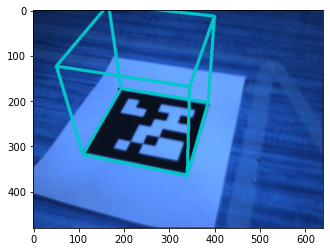

In [39]:
plt.imshow(cube_projection)